### **Importação das bibliotecas necessárias**

In [1]:
import os
import cv2
import random
import itertools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, concatenate, add
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import log_loss, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

2021-10-23 13:12:46.694692: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


### **Leitura e pre-processamentos dos dados**

In [2]:
train_generator = ImageDataGenerator(rescale=1./255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

train_generator = train_generator.flow_from_directory(
        '../input/train-val-test-tcga-coad-msi-mss/tcga_coad_msi_mss/train',  
        target_size=(150,150),  
        batch_size=64,
        class_mode='binary')

test_generator = ImageDataGenerator(rescale=1.0/255)

validation_generator = test_generator.flow_from_directory(
        '../input/train-val-test-tcga-coad-msi-mss/tcga_coad_msi_mss/val',  
        target_size=(150,150),  
        batch_size=64,
        class_mode='binary')

test_generator = test_generator.flow_from_directory(
       '../input/train-val-test-tcga-coad-msi-mss/tcga_coad_msi_mss/test',  
        target_size=(150,150),  
        batch_size=64,
        class_mode='binary')

Found 153849 images belonging to 2 classes.
Found 19230 images belonging to 2 classes.
Found 19233 images belonging to 2 classes.


## **Definindo funções de métricas de avaliação do modelo**

In [3]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [4]:
def create_model():
    model_vgg16 = VGG16(weights='imagenet',
                        include_top=False, 
                        input_shape=(150, 150, 3))
    
    for layer in model_vgg16.layers[:]:
        layer.trainable = False

    for layer in model_vgg16.layers:
        print(layer, layer.trainable)
    
    model = Sequential()
    model.add(model_vgg16)
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))   
    model.summary()
    sgd = SGD(lr=1e-3)

    model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=2e-5), metrics=['acc',f1_m])
    #model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['acc',f1_m])
    return model
    

In [5]:
model = create_model()

2021-10-23 13:15:03.737889: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-23 13:15:03.741405: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-23 13:15:03.799924: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-23 13:15:03.800998: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-23 13:15:03.801091: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-23 13:15:03.826970: I tensorflow/stream_executor/platform/def

58892288/58889256 [==============================] - 0s 0us/step
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f9355458c10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f93128e3bd0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f93128aad90> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f931283af90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f931283a950> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f93128e3b50> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9312395d10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f931239e050> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9312395210> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f93123a3f50> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f93123aea10> Fals

In [6]:
history = model.fit(
       train_generator,
       epochs=25,
       validation_data=test_generator)

2021-10-23 13:15:07.710480: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-23 13:15:07.714129: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000179999 Hz


Epoch 1/25


2021-10-23 13:15:08.746773: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-23 13:15:09.561200: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-10-23 13:15:09.729994: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


2404/2404 [==============================] - 2243s 929ms/step - loss: 0.7498 - acc: 0.5903 - f1_m: 0.6801 - val_loss: 0.6401 - val_acc: 0.6478 - val_f1_m: 0.7043
Epoch 2/25
2404/2404 [==============================] - 1227s 510ms/step - loss: 0.6446 - acc: 0.6424 - f1_m: 0.7354 - val_loss: 0.6443 - val_acc: 0.6512 - val_f1_m: 0.6965
Epoch 3/25
2404/2404 [==============================] - 1235s 514ms/step - loss: 0.6312 - acc: 0.6556 - f1_m: 0.7448 - val_loss: 0.6419 - val_acc: 0.6640 - val_f1_m: 0.7161
Epoch 4/25
2404/2404 [==============================] - 1219s 507ms/step - loss: 0.6286 - acc: 0.6624 - f1_m: 0.7515 - val_loss: 0.6430 - val_acc: 0.6703 - val_f1_m: 0.7216
Epoch 5/25
2404/2404 [==============================] - 1234s 513ms/step - loss: 0.6296 - acc: 0.6682 - f1_m: 0.7565 - val_loss: 0.6365 - val_acc: 0.6724 - val_f1_m: 0.7252
Epoch 6/25
2404/2404 [==============================] - 1224s 509ms/step - loss: 0.6193 - acc: 0.6706 - f1_m: 0.7575 - val_loss: 0.6298 - val_acc:

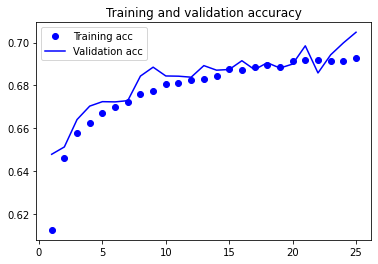

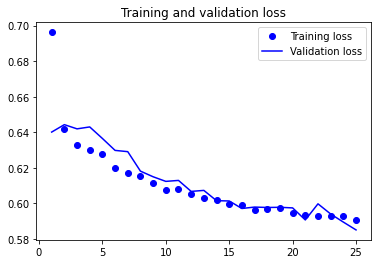

In [7]:
acc = history.history['acc']

val_acc = history.history['val_acc'] 
loss = history.history['loss']
val_loss = history.history['val_loss'];
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend(loc='best')

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='best')


In [8]:
n_test = 19233
Y_pred = model.predict_generator(test_generator, n_test//64+1)
y_pred = np.argmax(Y_pred, axis=1)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [9]:
target_names=['MSI', 'MSS']

In [10]:
from sklearn.metrics import classification_report

In [11]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

In [12]:
from tensorflow.keras.models import model_from_json

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")

In [13]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 512)         2048      
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,814,401
Trainable params: 2,098,689
Non-trainable params: 14,715,712
____________________________________

In [15]:
loss, acc, f1_m= model.evaluate(test_generator.classes, y_pred)

ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1233 test_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1224 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1217 run_step  **
        outputs = model.test_step(data)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1183 test_step
        y_pred = self(x, training=False)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:375 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:425 call
        inputs, training=training, mask=mask)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:425 call
        inputs, training=training, mask=mask)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:239 assert_input_compatibility
        str(tuple(shape)))

    ValueError: Input 0 of layer block1_conv1 is incompatible with the layer: : expected min_ndim=4, found ndim=2. Full shape received: (None, 1)
